In [1]:
import pandas as pd
import numpy as np

In [2]:
fn_df = pd.read_csv('FakeReal_News_Sites.csv', index_col=[0])
fn_df.head()
# fn_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# fn_df.fillna(0, inplace=True)


,Domain,Page rank integer,Page rank decimal,Site Rank,Domain registrar,Postal code,Country of origin,Harmless,Malicious,Suspicious,Undetected,Timeout,No. of Local links,No. of Outbound links,Total links,Links to fake news site?,Wordpress?,Site Rating
0,actionnews3.com,3,2.82,7390112.0,"GoDaddy.com, LLC",85284,US,86,0,0,10,0,16,1,17,False,True,Fake
1,abcnews-us.com,3,2.89,6579810.0,NamePal.com #8009 Inc.,32256,US,86,0,0,10,0,0,1,1,False,False,Fake
2,21stcenturywire.com,5,4.57,66742.0,"GoDaddy.com, LLC",85284,US,83,0,0,13,0,183,36,219,False,True,Fake
3,100percentfedup.com,4,4.15,778723.0,"GoDaddy.com, LLC",85284,US,84,1,0,11,0,49,8,57,False,True,Fake
4,abcnews.com,5,4.78,32787.0,"CSC CORPORATE DOMAINS, INC.",10023-6298,US,83,0,0,13,0,0,144,144,False,False,Fake


In [3]:
fn_df.isnull().any()

Domain                      False
Page rank integer           False
Page rank decimal           False
Site Rank                    True
Domain registrar             True
Postal code                  True
Country of origin            True
Harmless                    False
Malicious                   False
Suspicious                  False
Undetected                  False
Timeout                     False
No. of Local links          False
No. of Outbound links       False
Total links                 False
Links to fake news site?    False
Wordpress?                  False
Site Rating                 False
dtype: bool

In [4]:
fn_df.fillna({'Site Rank':0, 'Domain registrar':'None', 'Postal code':'None', 'Country of origin':'None'}, inplace=True)


In [5]:
fn_df.isnull().any()

Domain                      False
Page rank integer           False
Page rank decimal           False
Site Rank                   False
Domain registrar            False
Postal code                 False
Country of origin           False
Harmless                    False
Malicious                   False
Suspicious                  False
Undetected                  False
Timeout                     False
No. of Local links          False
No. of Outbound links       False
Total links                 False
Links to fake news site?    False
Wordpress?                  False
Site Rating                 False
dtype: bool

In [6]:
fn_df[(fn_df['Site Rating'] == 'Fake')].shape[0]

149

In [7]:
fn_df.loc[fn_df['Malicious'] > 0, 'Malicious'] = 1

In [8]:
#unnecessary columns = Links to fake news site?, Suspicious, and No. of Outbound links
X = fn_df[['Domain registrar', 'Postal code',
       'Wordpress?', 'Page rank decimal', 'Site Rank', 'Country of origin',
       'Malicious', 'No. of Local links', 'Total links']]

y = fn_df['Site Rating']


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

xgb = XGBClassifier()

le = LabelEncoder()
y = le.fit_transform(y)

cat_cols = ['Postal code', 'Country of origin']
bin_cols = ['Wordpress?', 'Malicious']
num_cols = ['Page rank decimal','Site Rank', 'Total links']

ct = ColumnTransformer([('standard_scaler', StandardScaler(), num_cols),
                        ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown= "ignore"), cat_cols),
                        ('label_encoder', OrdinalEncoder(), bin_cols)])



In [10]:
from sklearn.model_selection import GridSearchCV

params={
 "learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20, 0.25] ,
 "max_depth"        : [ 3, 4, 5, 6, 9, 12],
 "min_child_weight" : [ 1, 3, 5, 7, 9, 11 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.9, 0.11 ]
    
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 5,
    verbose=True,
    return_train_score=True
)





In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [13]:
clfXGB_gs = Pipeline(steps = [('preprocessor', ct), ('XGBoost', grid_search)])
clfXGB_gs.fit(X_train, y_train)


Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
[17:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['Page rank decimal',
                                                   'Site Rank',
                                                   'Total links']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Postal code',
                                                   'Country of origin']),
                                                 ('label_encoder',
                                                  OrdinalEncoder(),
                                                  ['Wordpress?',
                                                   'Malicious'])])),
                ('XGBoost',
                 GridSearchCV(cv=5,
                              estima...
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None),
                              n_jobs=5,
                              param_grid={'colsample_bytree': [0.3, 0.4, 0.5,
                                                               0.7, 0.9, 0.11],
                                          'gamma': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                    0.5],
                                          'learning_rate': [0.01, 0.05, 0.1,
                                                            0.15, 0.2, 0.25],
                                          'max_depth': [3, 4, 5, 6, 9, 12],
                                          'min_child_weight': [1, 3, 5, 7, 9,
                                                               11]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=True))])

In [112]:
import matplotlib.pyplot as plt
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='none',figsize=(30,6))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

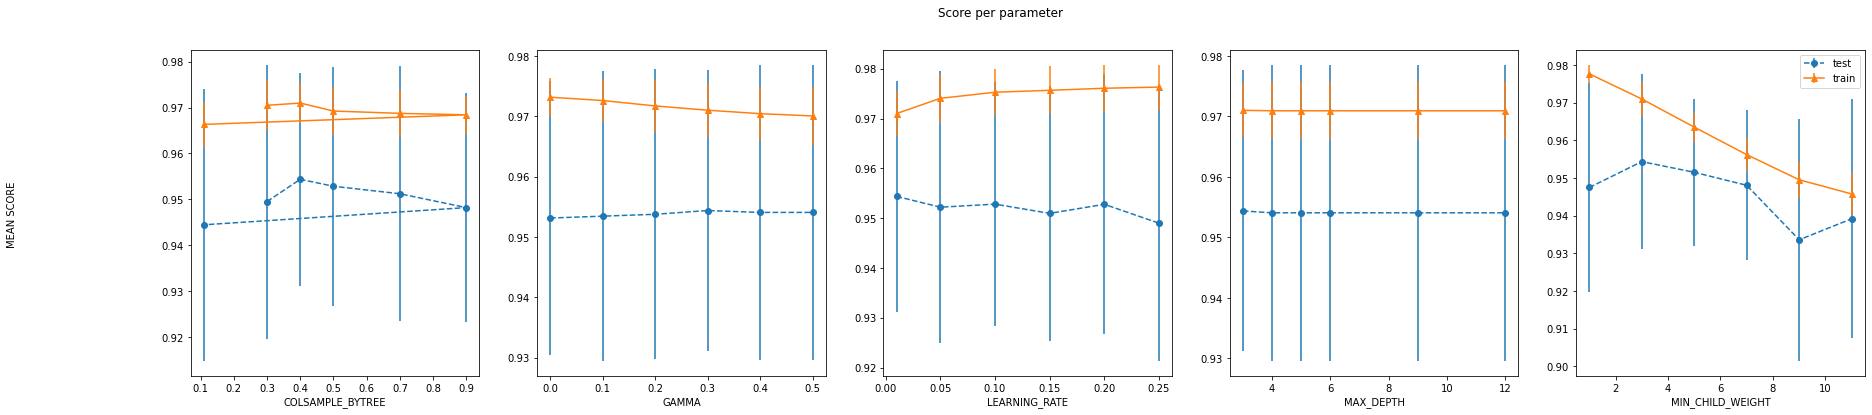

In [113]:
plot_search_results(grid_search)

In [15]:
grid_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.3,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 3}

In [16]:
grid_search.best_score_

0.954368530020704

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score

clfXGB_nocv = Pipeline(steps = [('preprocessor', ct), ('XGBoost', XGBClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

models = [clfXGB_nocv]
model_scores={}

for idx, model in enumerate(models):
    model.fit(X_train, y_train)
    name = list(model.named_steps)[1]
    
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    
    model_scores[name] = score, mae, mse, f1
    

    joblib.dump(model, f'{name}Classifier.joblib')
    print(f'model {idx+1} done')

[21:03:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model 1 done


c:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [107]:
model_scores
#accuracy, mean absolute error, mean squared error, f1 score

{'XGBoost': (0.9148936170212766,
  0.0851063829787234,
  0.0851063829787234,
  0.909090909090909)}

In [19]:
#SVM
clfSVM = Pipeline(steps = [('preprocessor', ct), ('SVM', SVC())])
#logistic regression
clfLOGREG = Pipeline(steps = [('preprocessor', ct), ('Logistic Regression', LogisticRegression())])
#XGBoost
clfXGB = Pipeline(steps = [('preprocessor', ct), ('XGBoost', XGBClassifier(colsample_bytree= 0.4, gamma= 0.3, learning_rate= 0.01,max_depth= 3, min_child_weigh = 3))])
#Naive Bayes
clfNB = Pipeline(steps = [('preprocessor', ct), ('Naive Bayes', GaussianNB())])
#Random forest
clfRFC = Pipeline(steps = [('preprocessor', ct), ('RFC', RandomForestClassifier())])
#neural netTODO



joblib.dump(ct, "SitePreprocessor.joblib")


['SitePreprocessor.joblib']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
models = [clfSVM, clfLOGREG, clfXGB, clfNB, clfRFC]

model_scores={}

for idx, model in enumerate(models):
    model.fit(X_train, y_train)
    name = list(model.named_steps)[1]
    
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    
    model_scores[name] = score, mae, mse, f1
    

    joblib.dump(model, f'{name}Classifier.joblib')
    print(f'model {idx+1} done')
    



model 1 done
model 2 done
[19:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_child_weigh" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model 3 done
model 4 done


c:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model 5 done


In [27]:
model_scores
#scores in order: accuracy, mean absolute error, mean squared error, f1 score

{'SVM': (0.9148936170212766,
  0.0851063829787234,
  0.0851063829787234,
  0.9047619047619048),
 'Logistic Regression': (0.9148936170212766,
  0.0851063829787234,
  0.0851063829787234,
  0.9047619047619048),
 'XGBoost': (0.9574468085106383,
  0.0425531914893617,
  0.0425531914893617,
  0.9523809523809523),
 'Naive Bayes': (0.6595744680851063,
  0.3404255319148936,
  0.3404255319148936,
  0.7142857142857142),
 'RFC': (0.9574468085106383,
  0.0425531914893617,
  0.0425531914893617,
  0.9545454545454545)}

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

clfXGB.fit(X_train, y_train)
print('Score: ',clfXGB.score(X_test, y_test))

[19:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_child_weigh" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score:  0.9574468085106383


c:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [93]:
y_pred = clfXGB.predict(X_test)

In [94]:
print(y_pred)
print(y_test)

[1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 1]
[1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 1]


In [95]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[20  1]
 [ 1 25]]
